# Challenge 1

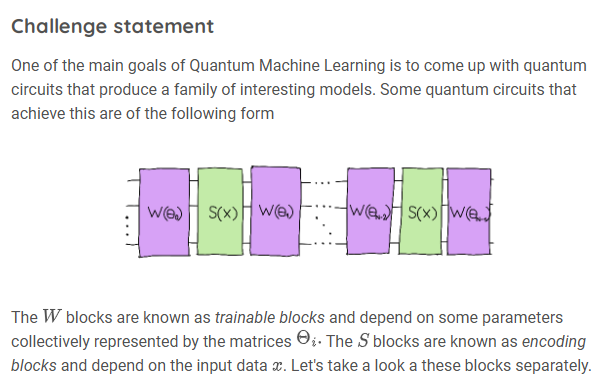


In [1]:
#!pip install pennylane

In [4]:
import json
import pennylane as qml
import pennylane.numpy as np

## create a function making a layer of trainable block

In [5]:
dev = qml.device("default.qubit", wires = 3)

@qml.qnode(dev)
def W(params):
    
    """
    Subcircuit that implements the trainable block W
    
    Args:
        params (np.array): A matrix containing the parameters for the trainable block W. The length of
        params is equal to the depth of the circuit. The length of each row in params is the number 
        of qubits used. See the challenge statement for a detailed explanation
    Returns:
        Since this function is a subcircuit, you must not return anything.
    
    """
    # Put your code here
    if len(params.shape) == 1:
        depth = 1
        n_qubits = params.shape[0]
    else:
        depth = params.shape[0]
        n_qubits = params.shape[1]

    #print('n_q: '+ str(n_qubits) +' \ndepth: ' + str(depth))
    
    
    qml.registers({"q_reg": n_qubits})
    for i in range(depth):
        for j in range(n_qubits):
            qml.RY(params[i][j], wires = j)
        if n_qubits > 1:
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i+1])
            qml.CNOT(wires=[n_qubits-1, 0])


        
    
    ret = []
    for i in range(n_qubits):
        ret.append(qml.expval(qml.PauliZ(i)))
    return ret

In [6]:
params = np.array([[0.5,2,2],[1,2,2]])
W(params)

[tensor(0.32433194, requires_grad=True),
 tensor(0.41567282, requires_grad=True),
 tensor(-0.35396279, requires_grad=True)]

In [7]:
circuit = W(params)

C:\Users\Oleg\AppData\Local\Temp\ipykernel_21388\4177584200.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


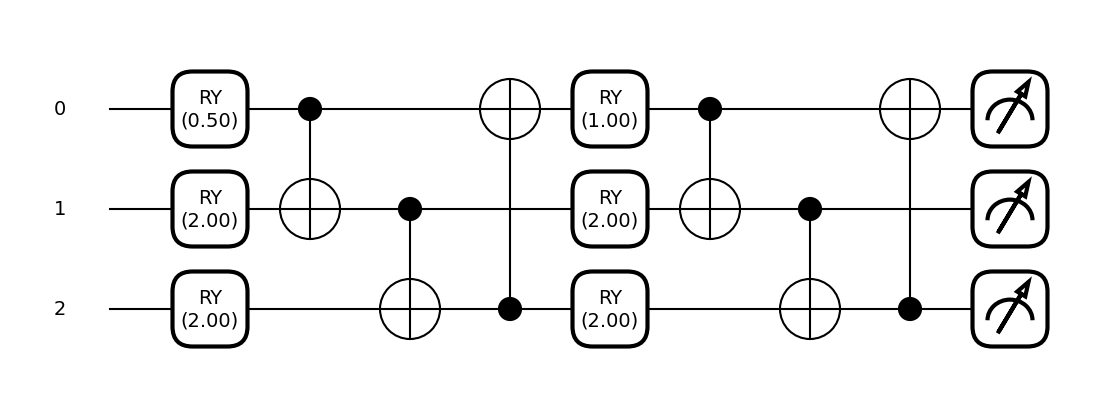

In [8]:
import matplotlib.pyplot as plt
fig, ax = qml.draw_mpl(W, decimals=2)(params)
fig.show()

## Create a function making an encoding block

In [23]:
import math
def hami(wire_num):
    return qml.Hamiltonian([1], [qml.PauliX(wire_num)])

def my_quantum_function():
    qml.exp(op, coeff = 1j*0.1)
    return qml.expval(qml.PauliZ(1))


def en_block(g, x, bit_size):
    qml.registers({"q_reg": bit_size})
    for i in range(bit_size):
        qq = g(i) #a = 1#
        qml.exp(qq, coeff = 1j * x)
    ret = []
    for i in range(bit_size):
        ret.append(qml.expval(qml.PauliZ(i)))
    return ret

en_block(hami, 0.1, 2)
#op_1 = math.cos(x) + 1j * math.sin(x) * op

1 * X(1)


[expval(Z(0)), expval(Z(1))]

C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\drawer\mpldrawer.py:580: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from font(s) DejaVu Sans.
  bbox = text_obj.get_window_extent(renderer)
C:\Users\Oleg\AppData\Local\Temp\ipykernel_21388\695404060.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


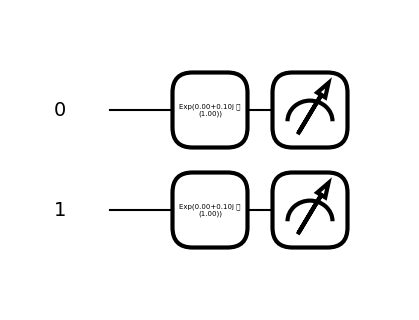

In [26]:
import matplotlib.pyplot as plt
params = np.array([hami, 0.1, 2])
fig, ax = qml.draw_mpl(en_block, decimals=2)(hami, 0.1, 2)
fig.show()

In [ ]:
dev = qml.device("default.qubit", wires = 3)

@qml.qnode(dev)
def S(g, x, num_wires):
    
    """
    Subcircuit that implements the encoding block S
    
    Args:
        g (pennylane.Operator): A PennyLane operator representing the generator for the encoding
        gates. It must be Hermitian in order to generate a unitary. Call it as g(wires) to specify
        the wires on which it acts.
        x (complex): The scalar coefficient of the operator g.
        num_wires (int): The number of wires over which the encoding gate is broadcast.
        
        
    Returns:
        Since this function is a subcircuit, you must not return anything.
    
    """
    
    
    